In [1]:
# Import Library
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load Dataset
train_dir = 'split_dataset/train/'
val_dir = 'split_dataset/val/'
test_dir = 'split_dataset/test/'
os.listdir(train_dir)

['cengkeh',
 'jahe',
 'kapulaga',
 'kencur',
 'kunyit',
 'lada hitam',
 'lada putih',
 'laos',
 'pala',
 'temulawak']

In [3]:
# Parameter
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.0001

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 1050 images belonging to 10 classes.


In [7]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 150 images belonging to 10 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 300 images belonging to 10 classes.


In [9]:
# Load MobileNetV2 without fully connected layer (include_top=False)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze layer from MobileNetV2 for transfer learning
base_model.trainable = False

# Add custom layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 unit
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.5)(x)  # Dropout
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer with softmax

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,584,074 (13.67 MB)

 Trainable params: 1,324,042 (5.05 MB)

 Non-trainable params: 2,260,032 (8.62 MB)

In [11]:
# Callback early stopping with patience 10
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [12]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping]  # Add callback early stopping
)

Epoch 1/25


c:\Users\USER\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 414ms/step - accuracy: 0.3510 - loss: 2.3279 - val_accuracy: 0.8867 - val_loss: 0.6664
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step - accuracy: 0.8438 - loss: 0.4333 - val_accuracy: 0.9133 - val_loss: 0.3842
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 377ms/step - accuracy: 0.9036 - loss: 0.2804 - val_accuracy: 0.9333 - val_loss: 0.2446
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 379ms/step - accuracy: 0.9468 - loss: 0.1778 - val_accuracy: 0.9533 - val_loss: 0.1601
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 381ms/step - accuracy: 0.9287 - loss: 0.1868 - val_accuracy: 0.9800 - val_loss: 0.1122
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 384ms/step - accuracy: 0.9662 - loss: 0.1224 - val_accuracy: 0.9667 - val_loss: 0.0924
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 389ms/step - accuracy: 0.9738 - loss: 0.0942 - val_accuracy: 0.9933 - val_loss: 0.0692
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.9604 - loss: 0.1098 - val_accuracy: 0.980

In [13]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc}')

10/10 - 2s - 205ms/step - accuracy: 0.9867 - loss: 0.0418
Test accuracy: 0.9866666793823242


In [14]:
# Make predictions on the test data
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step


In [15]:
# True classes
true_classes = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

In [16]:
# Get class labels
class_labels = list(test_generator.class_indices.keys())

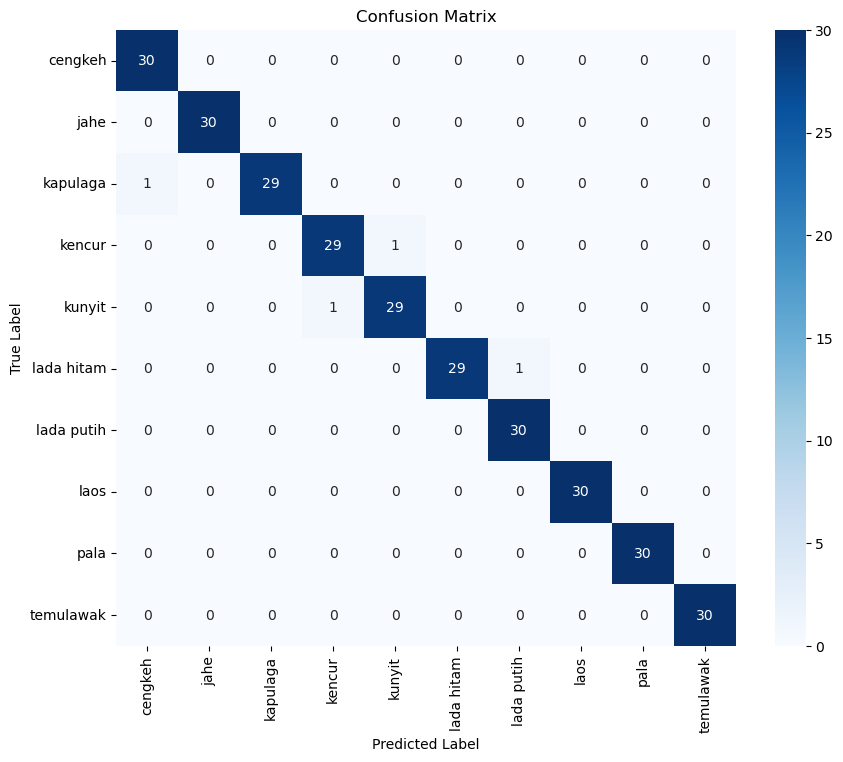

              precision    recall  f1-score   support

     cengkeh       0.97      1.00      0.98        30
        jahe       1.00      1.00      1.00        30
    kapulaga       1.00      0.97      0.98        30
      kencur       0.97      0.97      0.97        30
      kunyit       0.97      0.97      0.97        30
  lada hitam       1.00      0.97      0.98        30
  lada putih       0.97      1.00      0.98        30
        laos       1.00      1.00      1.00        30
        pala       1.00      1.00      1.00        30
   temulawak       1.00      1.00      1.00        30

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [17]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [18]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

class_labels = ["Cengkeh", "Jahe", "Kapulaga", "Kencur", "Kunyit", "Lada Hitam", "Lada Putih", "Laos", "Pala", "Temulawak"]
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
accuracy = accuracy_score(true_classes, predicted_classes)

df = pd.DataFrame(report).transpose()
df = df.loc[class_labels]
df['Accuracy'] = round(accuracy, 2)
df = df[['precision', 'recall', 'f1-score', 'Accuracy']]
df = df.round(2)

print(df)

            precision  recall  f1-score  Accuracy
Cengkeh          0.97    1.00      0.98      0.99
Jahe             1.00    1.00      1.00      0.99
Kapulaga         1.00    0.97      0.98      0.99
Kencur           0.97    0.97      0.97      0.99
Kunyit           0.97    0.97      0.97      0.99
Lada Hitam       1.00    0.97      0.98      0.99
Lada Putih       0.97    1.00      0.98      0.99
Laos             1.00    1.00      1.00      0.99
Pala             1.00    1.00      1.00      0.99
Temulawak        1.00    1.00      1.00      0.99


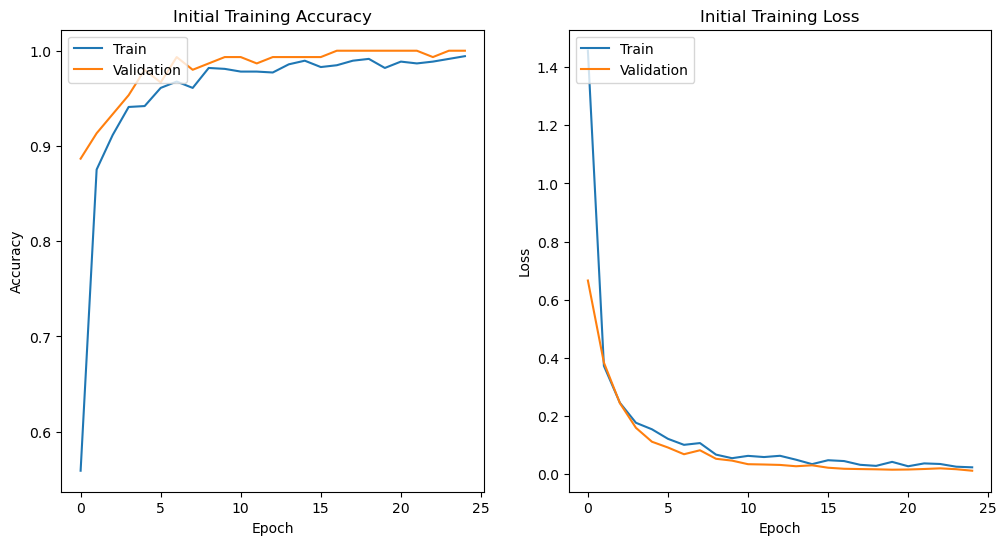

In [19]:
# Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Initial Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Initial Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')